导入基础库

In [1]:
import sys
sys.path.append("/Users/yumingmin/MCode/MachineLearning/")

# 1. 从零开始实现多层感知机

In [2]:
import torch
from torch import nn
from utils import Accumulator
from utils.downloader import load_data_fashion_mnist
from utils.plot import Animator

## 1.1 Accuracy

In [3]:
def accuracy(y_hat, y):
    "计算预测正确的数量"
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    # y_hat.type(y.dtype): 将 y_hat 转换成 y 的数据类型
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.sum())

## 1.2 Eavluate Accuracy

In [4]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    # y.numel(): 获取元素个数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [5]:
def train_epoch(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用 PyTorch 内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat, y),
                y.size().numel()
            )
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [6]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel="epoch", xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=["train loss", "train acc", "test acc"])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

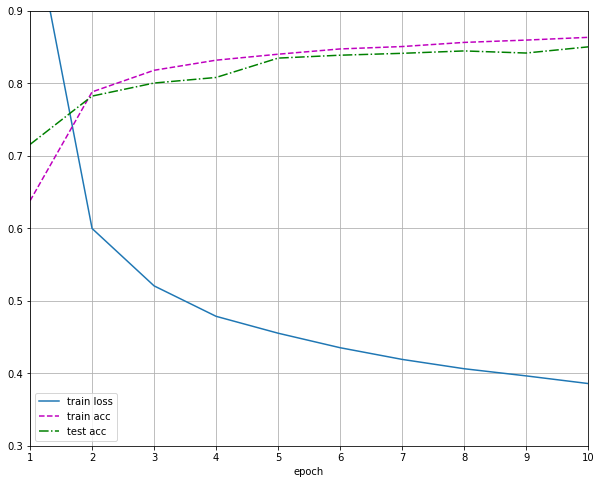

In [8]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10))
net.apply(init_weights)

loss = nn.CrossEntropyLoss()
num_epochs, lr = 10, 0.1
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, loss, num_epochs, trainer)